# Dilated Convolution (Atrous Convolution) — Teori ve Uygulama

Bu defterde **Dilated Convolution (Atrous Convolution)** kavramını ayrıntılı şekilde inceleyeceğiz:

- Dilated conv nedir, normal conv'dan farkı ne?
- Dilation ile **receptive field** nasıl büyür?
- PyTorch'ta `dilation` ve `padding` ilişkisi
- Basit dilated conv örnekleri
- Multi-Scale Dilation bloğu (dilation=1,2,4 paralel)
- Normal conv ile dilated conv arasındaki sezgisel farklar

Hedef, dilated conv'u sadece bir parametre olarak değil,
**receptive field kontrol aracı** olarak kafanda netleştirmek.


## 1. Dilated Convolution Nedir?

Normal bir 3×3 konvolüsyon düşün:

- Kernel elemanları bitişik konumlanır.
- Merkez piksel + etrafındaki 8 komşuyu kapsar.

**Dilated convolution** ise kernel elemanları arasına **boşluk** koyar.

- `dilation = 1` → normal conv
- `dilation = 2` → her kernel elemanı arasında 1 piksel boşluk
- `dilation = 3` → arada 2 piksel boşluk
- ...

Bu sayede:

> Receptive field büyür,  
> ancak kernel boyutu ve parametre sayısı aynı kalır.

Örnek:

- 3×3, dilation=1 → 3×3'lük alanı görür (normal)
- 3×3, dilation=2 → 5×5'lik alanı görür (parametre yine 9)
- 3×3, dilation=3 → 7×7'lik alanı görür (parametre yine 9)


## 2. Effective Kernel Size ve Dilation

Dilation, "etkin kernel boyutunu" değiştirir.

Genel formül:

\[
k_{\text{eff}} = \text{dilation} \cdot (k - 1) + 1
\]

Burada:

- `k` → gerçek kernel boyutu (örneğin 3)
- `dilation` → atlama miktarı
- `k_eff` → konvolüsyonun gerçekte kapsadığı alanın boyutu

Örnekler:

- `k=3`, `dilation=1` → \( k_{eff} = 1 \cdot (3-1) + 1 = 3 \)
- `k=3`, `dilation=2` → \( k_{eff} = 2 \cdot 2 + 1 = 5 \)
- `k=3`, `dilation=3` → \( k_{eff} = 3 \cdot 2 + 1 = 7 \)

Yani 3×3 kernel:

- dilation=1 ile 3×3 gibi davranır,
- dilation=2 ile 5×5 gibi,
- dilation=3 ile 7×7 gibi davranır.

Parametre sayısı ise hala **k × k × C_in × C_out** olarak kalır.


## 3. PyTorch'ta Dilated Conv ve Padding İlişkisi

PyTorch'ta `nn.Conv2d` fonksiyonu:

```python
nn.Conv2d(
    in_channels,
    out_channels,
    kernel_size,
    stride=1,
    padding=0,
    dilation=1,
    ...
)
```

Çıkış boyutunu (H yönünde) veren formül:

\[
H_{out} = \left\lfloor \frac{H_{in} + 2 \cdot \text{padding} - \text{dilation} \cdot (k - 1) - 1}{\text{stride}} \right\rfloor + 1
\]

Buradaki kritik kısım:

- `dilation * (k - 1)` terimi,
- Etkin kernel boyutunu \( k_{eff} = \text{dilation}(k-1)+1 \) olarak belirliyor.

Eğer `stride = 1` ve **boyutu sabit tutmak** istiyorsan (same padding yaklaşımı):

\[
\text{padding} = \frac{k_{eff} - 1}{2}
\]

Örnekler (k=3 için):

- dilation=1 → k_eff = 3 → padding = 1
- dilation=2 → k_eff = 5 → padding = 2
- dilation=3 → k_eff = 7 → padding = 3


In [ ]:
import torch
import torch.nn as nn

# Girdi tensörü: (N, C, H, W)
x = torch.randn(1, 32, 32, 32)

# Normal 3x3 Conv (dilation=1, padding=1)
conv_normal = nn.Conv2d(
    in_channels=32,
    out_channels=64,
    kernel_size=3,
    padding=1,
    dilation=1
)

# Dilated 3x3 Conv (dilation=2, padding=2) -> effective kernel: 5x5
conv_dilated_2 = nn.Conv2d(
    in_channels=32,
    out_channels=64,
    kernel_size=3,
    padding=2,
    dilation=2
)

y_norm = conv_normal(x)
y_dil  = conv_dilated_2(x)

print("Normal conv output shape :", y_norm.shape)   # (1, 64, 32, 32)
print("Dilated conv output shape:", y_dil.shape)    # (1, 64, 32, 32)


Normal conv output shape : torch.Size([1, 64, 32, 32])
Dilated conv output shape: torch.Size([1, 64, 32, 32])


Yukarıdaki örnekte:

- Hem normal hem dilated conv, `H=W=32` boyutunu koruyor.
- Ancak dilated conv, **daha geniş bir receptive field** ile aynı feature map boyutunu üretiyor.


## 4. Multi-Scale Dilated Convolution Bloğu

"Multi-scale dilation" denildiğinde kastedilen şey genelde:

> Aynı girdiyi birden fazla dilation değeriyle (1,2,4 gibi) paralel işleyip
> bu feature map'leri birleştirmek.

Amaç:

- Küçük dilation → **lokal** bilgi,
- Orta dilation → **orta ölçekli** bağlam,
- Büyük dilation → **geniş ölçekli** bağlam.

Aşağıda 3 dallı (dilation=1,2,4) bir multi-scale dilated block örneği var.


In [3]:
class MultiScaleDilatedBlock(nn.Module):
    """
    Aynı girdiyi 3 farklı dilation ile işler:
    - 3x3, dilation=1
    - 3x3, dilation=2
    - 3x3, dilation=4
    Sonra concat edip 1x1 conv ile tekrar karıştırır.
    """
    def __init__(self, c_in, c_out):
        super().__init__()

        # Her branch'in üreteceği kanal sayısı
        c_branch = c_out // 3
        if c_branch == 0:
            c_branch = c_out  # çok küçük c_out için fallback

        # effective kernel = d*(k-1)+1 = 3, 5, 9

        # Branch 1: dilation=1 (lokal)
        self.branch1 = nn.Conv2d(
            c_in, c_branch,
            kernel_size=3,
            padding=1,     # k_eff=3 -> padding=1
            dilation=1,
            bias=False
        )

        # Branch 2: dilation=2 (orta ölçek)
        self.branch2 = nn.Conv2d(
            c_in, c_branch,
            kernel_size=3,
            padding=2,     # k_eff=5 -> padding=2
            dilation=2,
            bias=False
        )

        # Branch 3: dilation=4 (geniş ölçek)
        self.branch3 = nn.Conv2d(
            c_in, c_branch,
            kernel_size=3,
            padding=4,     # k_eff=9 -> padding=4
            dilation=4,
            bias=False
        )

        # Concat sonrası BN + aktivasyon
        self.bn = nn.BatchNorm2d(c_branch * 3)

        # 1x1 projection ile C_out'e dön
        self.project = nn.Conv2d(
            in_channels=c_branch * 3,
            out_channels=c_out,
            kernel_size=1,
            bias=False
        )

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)

        # Kanal boyutunda birleştir
        out = torch.cat([b1, b2, b3], dim=1)
        out = self.bn(out)
        out = torch.relu(out)
        out = self.project(out)
        out = torch.relu(out)
        return out

# Küçük test
x = torch.randn(1, 32, 32, 32)
block = MultiScaleDilatedBlock(c_in=32, c_out=64)
y = block(x)

print("Girdi şekli       :", x.shape)  # (1, 32, 32, 32)
print("Block çıktı şekli :", y.shape)  # (1, 64, 32, 32)


Girdi şekli       : torch.Size([1, 32, 32, 32])
Block çıktı şekli : torch.Size([1, 64, 32, 32])


Bu blok:

- Girdiyi 3 farklı ölçekten görüyor (3, 5, 9 effective kernel),
- Çıktıyı tekrar `C_out` kanala projekte ediyor,
- Boyutu (H, W) sabit tutuyor.

Semantic segmentation / context aggregation gibi işlerde bu tür bloklar yoğun şekilde kullanılıyor.


## 5. Dilated Conv Ne Zaman Kullanılır?

**Avantajlar:**

- Receptive field'i artırır (daha geniş bağlam),
- Parametre sayısını artırmadan bunu yapar,
- Özellikle aşağıdaki görevlerde çok kullanılır:
  - Semantic segmentation (DeepLab, ASPP vb. yapılar),
  - Context aggregation gereken dense prediction problemleri,
  - Ses / zaman serisi modellerinde uzun bağlam görmek için.

**Dikkat edilmesi gerekenler:**

- Çok büyük dilation değerleri "gridding" artefact'larına sebep olabilir:
  - Kernel noktaları, giriş uzayında "ızgara" gibi dağılır,
  - Bazı ara piksel bilgileri tamamen atlanmış olur.
- Bu yüzden genelde:
  - Farklı dilation değerleri kombinasyon halinde kullanılır (multi-scale),
  - Ya da katmanlar boyunca kademeli olarak artırılır (1,2,4,8 gibi).


## 6. Kısa Özet

- **Dilated Convolution**, kernel elemanları arasına boşluk koyarak
  receptive field'i büyütür.
- Effective kernel boyutu:

  \[ k_{eff} = \text{dilation} (k - 1) + 1 \]

- Boyutu korumak için (stride=1):

  \[ \text{padding} = (k_{eff} - 1) / 2 \]

- PyTorch'ta tek yapman gereken:
  ```python
  nn.Conv2d(in_c, out_c, kernel_size=3, padding=2, dilation=2)
  ```

- Multi-scale dilation blokları, farklı dilation değerlerini paralel kullanarak
  hem lokal hem global bağlamı toparlar.

Bu defterdeki örnekleri kendi model iskeletine entegre ederek,
"normal conv katmanlarını" dilated conv ile değiştirebilir ve
receptive field üzerinde daha bilinçli oynamaya başlayabilirsin.


---
---

# 1. Temel Setup: “Ben normal 3×3 conv’u dilated yapmak istiyorum”

* Referans noktamız şu klasik conv olsun:

```python
nn.Conv2d(
    in_channels=C_in,
    out_channels=C_out,
    kernel_size=3,
    stride=1,
    padding=1,
    dilation=1
)
```
**Bunu “dilated” yapmak için:**

* kernel_size = 3 çoğu zaman aynı kalır.

* stride = 1 bırak (receptive field büyütmek istiyoruz, downsample değil).

* dilation = d seçeceksin (1, 2, 3, 4 …)

* padding’i dilation’a göre ayarlayacaksın.


**Kural (k=3 için):**
```python
effective_kernel = dilation * (k - 1) + 1 = 2*d + 1
```

#### Boyutu korumak için (stride=1):
* padding = d

Tablo (k=3): 

| dilation | effective kernel | padding |
| -------- | ---------------- | ------- |
| 1        | 3×3              | 1       |
| 2        | 5×5              | 2       |
| 3        | 7×7              | 3       |
| 4        | 9×9              | 4       |

**Yani:**
```python
# 3x3, dilation=2 -> 5x5 gibi davranır, boyut korumak için padding=2
conv_d2 = nn.Conv2d(C_in, C_out, kernel_size=3, stride=1, dilation=2, padding=2)
```


---

# 2. Genel formül (her kernel için)

Eğer 3 dışında bir kernel kullanırsan:

```bash
k_eff = dilation*(k−1)+1
```
* Stride=1 ve boyutu korumak istiyorsan:
```bash
padding = (k_eff-1) / 2
```
Örnek: kernel_size=5, dilation=2

* k_eff = 2*(5-1) + 1 = 9

* padding = (9 - 1)/2 = 4

### Kod:
```python
conv = nn.Conv2d(
    C_in, C_out,
    kernel_size=5,
    dilation=2,
    padding=4,  # boyut sabit kalsın diye
    stride=1
)
```

----

# 3. Dilation değerini nasıl seçeceğiz?

Bu artık tasarım kararı. Birkaç senaryo vereyim:

### a) Sadece biraz daha geniş görmek istiyorum

Özellikle backbone’in orta–son katmanlarında:

* Erken katmanlar: normal conv (d=1)

* Orta katmanlar: d=2

* Daha derin katmanlar: d=4 gibi

Örnek bir stage:
```python
# Stage içi:
conv1 = nn.Conv2d(C, C, kernel_size=3, stride=1, padding=1, dilation=1)
conv2 = nn.Conv2d(C, C, kernel_size=3, stride=1, padding=2, dilation=2)
```


Burada conv2, aynı H,W’de kalıp daha geniş context görüyor.

### b) Multi-scale (paralel branch) kullanacağım

Tipik pattern:

* Branch 1: d=1 → lokal

* Branch 2: d=2 → orta

* Branch 3: d=4 → geniş

Her birinin padding’ini ona göre ayarla, sonra concat:
```python
b1 = nn.Conv2d(C_in, C_b, kernel_size=3, dilation=1, padding=1)
b2 = nn.Conv2d(C_in, C_b, kernel_size=3, dilation=2, padding=2)
b3 = nn.Conv2d(C_in, C_b, kernel_size=3, dilation=4, padding=4)
```


Sonra:
```python
out = torch.cat([b1(x), b2(x), b3(x)], dim=1)  # (N, 3*C_b, H, W)
out = nn.Conv2d(3*C_b, C_out, kernel_size=1)(out)
````


Burada parametre ayarın şu kafada:

* Dilation değerleri: 1, 2, 4

* Padding: aynı değer (k=3 olduğundan)

* Son 1×1 conv ile kanal sayısını tekrar kontrol ediyorsun.

### c) Çok büyütürsem ne olur? (Gridding problemi)

Dilation’ı çok büyütürsen:

* Kernel noktaları girişte seyrek bir ızgara gibi dağılır,

* Aradaki bazı piksel lokasyonları hiç görülmeyebilir,

* Özellikle art arda büyük dilation değerleri kullanırsan gridding artefact’ları oluşur.

Bu yüzden pratikte:

* Çok büyük d=8,16 gibi değerleri üst üste koyma,

* Ya kademeli git (1→2→4→1→2 gibi),

* Ya da paralel multi-scale blok kullan.

----

# 4. Stride ne olmalı?

Dilated conv’ün ana amacı:

* Downsample etmeden receptive field büyütmek.

Bu yüzden:

* Çoğu durumda: stride = 1 kullan.

**Eğer aynı katta hem stride>1 hem dilation>1 yaparsan:**

* Özellikle feature haritasını çok agresif “zıplatmış” olursun,

* Bilgi kaybı artar.

Genel pattern:

* Downsample etmek istiyorsan → stride=2, dilation=1

* Context büyütmek istiyorsan → stride=1, dilation>1

---
# 5. Katman seviyesinde nasıl yerleştireceğiz?

Kabaca şöyle düşünebilirsin:

**Early layers (girişe yakın):**

* Normal conv (d=1), küçük receptive field

* Kenar, doku, low-level feature’lar

**Middle / Late layers:**

Dilation kullan:

* Ya tek: d=2, d=4

* Ya paralel: (1,2,4)

* Artık feature map zaten küçük (16×16, 8×8 gibi),
>burada dilation ile global context toplamak mantıklı.


```python
# 32x32 feature
conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1, dilation=1)

# 16x16 feature (stride ile downsample)
conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2, dilation=1)

# 16x16 aynı boyutta ama daha geniş context
conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=2, dilation=2)
```
----

# 6. Özet: “Parametre ayarı” için pratik reçete

1.) Başlangıç noktası

* kernel_size=3, stride=1, dilation=1, padding=1 (normal conv)

2.) Receptive field büyütmek istiyorsun, boyut sabit kalsın

* dilation = d seç (2,3,4)

* padding = d (k=3 için)

* stride = 1 bırak

3.) Multi-scale yapmak istiyorsun

*Birkaç paralel branch aç:*

* d=1, padding=1

* d=2, padding=2

* d=4, padding=4

*Her branch aynı H,W üretmeli → padding’leri doğru ayarla.*

* Concat + 1×1 conv ile C_out’a dön.

4.) Çok büyük dilation kullanıyorsan

*Art arda (d=8 → d=8) yapmak yerine:*

* Ya 1→2→4 gibi kademeli,

* Ya 1,2,4 paralel.

----
----
----

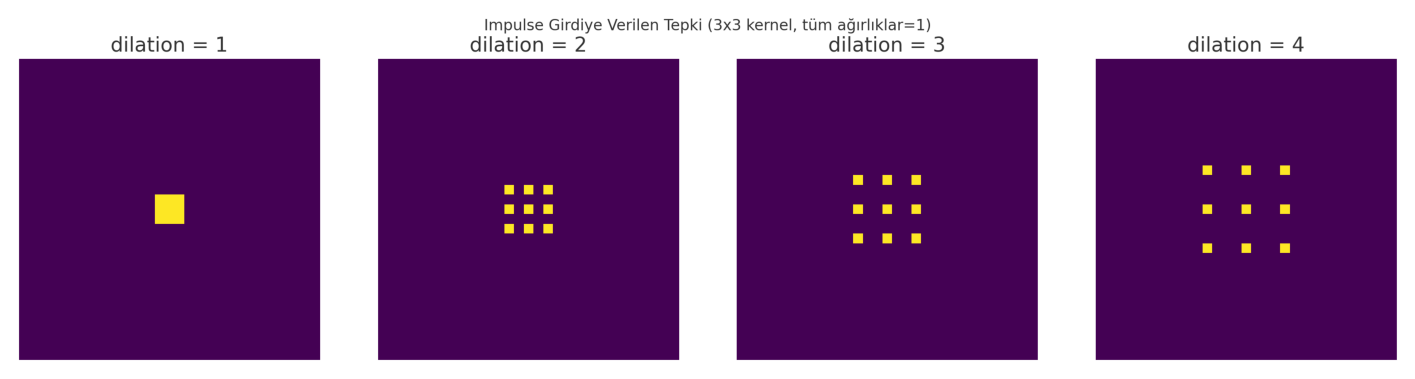

In [8]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = "dilated.png"  

img = Image.open(image_path)

plt.figure(figsize=(18, 15))
plt.imshow(img)
plt.axis("off")  
plt.show()

----
----